In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201111"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str22,str11,object,float64,int64,int64
BL_Lac-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-001R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-001V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lac-002B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-002R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-002V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lac-003B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-003R.fit,Light Frame,Bessel R,40.0,1024,1024
BL_Lac-003V.fit,Light Frame,Bessel V,60.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [7]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [8]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [9]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

802.2322578430176 2.2239
791.5 812.332852089363


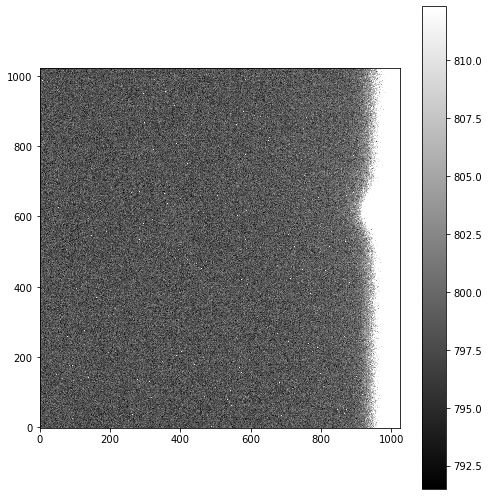

In [10]:
show_image(combined_bias)

0.17338981628417965 0.061775000000000024
-0.26560714112967077 0.6349782684858736


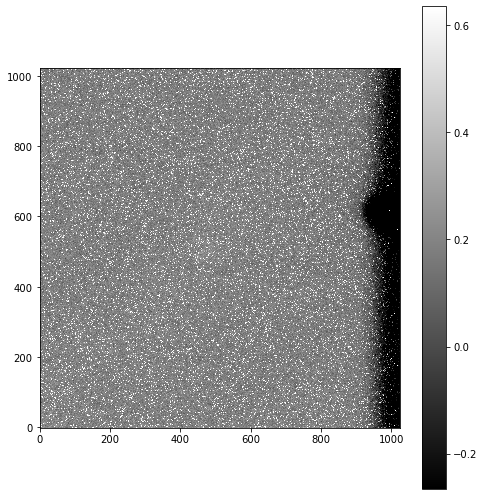

In [11]:
show_image(combined_darks)

0.9998123693417335 0.006553331942831694
0.969962406832322 1.0197596286526358


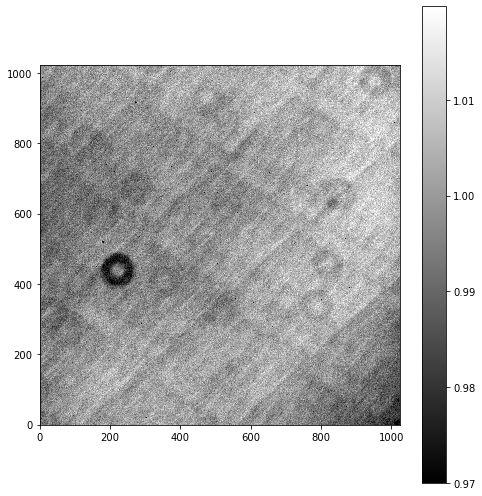

1.0000957841746865 0.006497582450239104
0.9700826582208815 1.0218885114898595


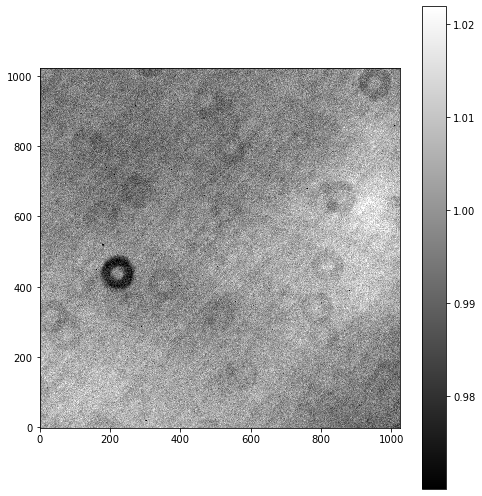

1.0044596382024094 0.010770061684005338
0.9657957999383782 1.0702479837977688


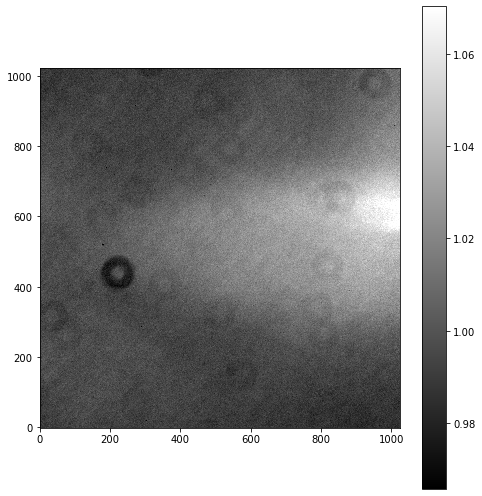

In [12]:
for filt,image in master_flats.items():
    show_image(image)

In [13]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

OSError: [Errno 28] No space left on device

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
185.43037429301899 11.702914543348427
111.45783230853364 258.7963698876216


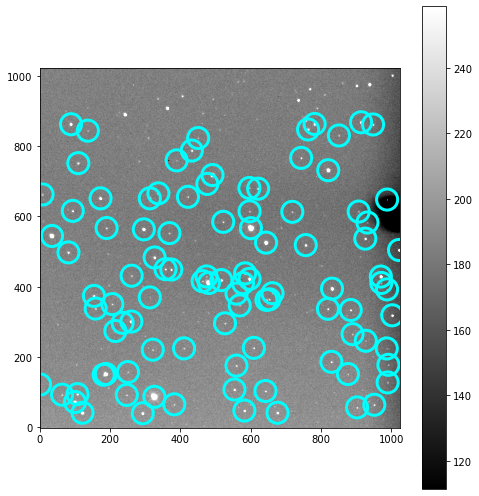

     xcentroid   ycentroid       mag
8   325.916441   87.051409 -7.009733
69  600.487913  566.811197 -6.527502
48  480.976499  410.765770 -6.294592
85  491.005436  718.037019 -4.661865
65   34.552679  544.693759 -4.444631
..         ...         ...       ...
91  450.397967  823.195252 -0.115963
88  389.100816  759.681911 -0.051364
93  136.454088  844.102764 -0.015451
41  312.792025  369.855383 -0.007236
84  476.328357  692.638706 -0.006553

[99 rows x 3 columns]
Point RA 23 41 49
Point Dec +44 10 47
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.45416667, 44.17972222)>
radecstr 355.454 44.1797
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.23592

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [3.84373580e+02 1.60032181e+00 2.76201013e-01]
dyfit [ 4.95322010e+02 -2.76349157e-01  1.59952782e+00]

scalex, scaley: 0.6157704475398712 0.6160576922570313
anglex, angley: -9.792262375763576 -9.802181846908352
fracdiffs: 0.0010129907435208706 0.0004664801929156072

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201111/Reduced_Images/BDF_HH_And-001R.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201111/Reduced_Images/BDF_HH_And-001R.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201111/Reduced_Images/BDF_HH_And-001R.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201111/Reduced_Images/BDF_HH_And-001R.match.transf

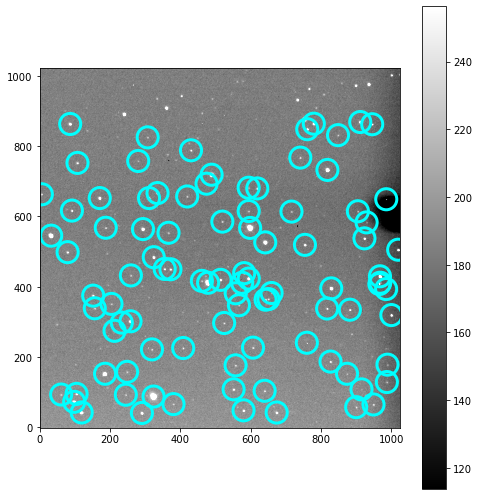

     xcentroid   ycentroid       mag
8   323.469030   87.770527 -6.780192
64  598.136041  567.568829 -6.323172
44  478.617343  411.517722 -6.013019
81  488.595108  718.856233 -4.454797
59  641.149536  526.343006 -4.349352
..         ...         ...       ...
14  915.068330  108.086952 -0.059592
66  929.517820  583.271507 -0.059309
84  279.793111  757.965481 -0.025839
46  968.309614  411.613943 -0.008683
20  989.009650  178.410588 -0.001785

[94 rows x 3 columns]
Point RA 23 41 49
Point Dec +44 10 47
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.45416667, 44.17972222)>
radecstr 355.454 44.1797
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.23592

In [15]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)